In [2]:
import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize
from sklearn import svm
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import confusion_matrix
from pylab import * 

In [11]:
def preprocess():
    """ 
     Input:
     Although this function doesn't have any input, you are required to load
     the MNIST data set from file 'mnist_all.mat'.

     Output:
     train_data: matrix of training set. Each row of train_data contains 
       feature vector of a image
     train_label: vector of label corresponding to each image in the training
       set
     validation_data: matrix of training set. Each row of validation_data 
       contains feature vector of a image
     validation_label: vector of label corresponding to each image in the 
       training set
     test_data: matrix of training set. Each row of test_data contains 
       feature vector of a image
     test_label: vector of label corresponding to each image in the testing
       set
    """

    mat = loadmat('mnist_all.mat')  # loads the MAT object as a Dictionary

    n_feature = mat.get("train1").shape[1]
    n_sample = 0
    for i in range(10):
        n_sample = n_sample + mat.get("train" + str(i)).shape[0]
    n_validation = 1000
    n_train = n_sample - 10 * n_validation

    # Construct validation data
    validation_data = np.zeros((10 * n_validation, n_feature))
    for i in range(10):
        validation_data[i * n_validation:(i + 1) * n_validation, :] = mat.get("train" + str(i))[0:n_validation, :]

    # Construct validation label
    validation_label = np.ones((10 * n_validation, 1))
    for i in range(10):
        validation_label[i * n_validation:(i + 1) * n_validation, :] = i * np.ones((n_validation, 1))

    # Construct training data and label
    train_data = np.zeros((n_train, n_feature))
    train_label = np.zeros((n_train, 1))
    temp = 0
    for i in range(10):
        size_i = mat.get("train" + str(i)).shape[0]
        train_data[temp:temp + size_i - n_validation, :] = mat.get("train" + str(i))[n_validation:size_i, :]
        train_label[temp:temp + size_i - n_validation, :] = i * np.ones((size_i - n_validation, 1))
        temp = temp + size_i - n_validation

    # Construct test data and label
    n_test = 0
    for i in range(10):
        n_test = n_test + mat.get("test" + str(i)).shape[0]
    test_data = np.zeros((n_test, n_feature))
    test_label = np.zeros((n_test, 1))
    temp = 0
    for i in range(10):
        size_i = mat.get("test" + str(i)).shape[0]
        test_data[temp:temp + size_i, :] = mat.get("test" + str(i))
        test_label[temp:temp + size_i, :] = i * np.ones((size_i, 1))
        temp = temp + size_i

    # Delete features which don't provide any useful information for classifiers
    sigma = np.std(train_data, axis=0)
    index = np.array([])
    for i in range(n_feature):
        if (sigma[i] > 0.001):
            index = np.append(index, [i])
    train_data = train_data[:, index.astype(int)]
    validation_data = validation_data[:, index.astype(int)]
    test_data = test_data[:, index.astype(int)]

    # Scale data to 0 and 1
    train_data /= 255.0
    validation_data /= 255.0
    test_data /= 255.0

    return train_data, train_label, validation_data, validation_label, test_data, test_label


In [12]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [13]:
def blrObjFunction(initialWeights, *args):
    """
    blrObjFunction computes 2-class Logistic Regression error function and
    its gradient.

    Input:
        initialWeights: the weight vector (w_k) of size (D + 1) x 1 
        train_data: the data matrix of size N x D
        labeli: the label vector (y_k) of size N x 1 where each entry can be either 0 or 1 representing the label of corresponding feature vector

    Output: 
        error: the scalar value of error function of 2-class logistic regression
        error_grad: the vector of size (D+1) x 1 representing the gradient of
                    error function
    """
    train_data, labeli = args

    n_data = train_data.shape[0]
    n_features = train_data.shape[1]
    error = 0
    error_grad = np.zeros((n_features + 1, 1))

    ##################
    # OUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data
    
    #adding Bias Term
    biasTerm = np.ones((train_data.shape[0],1))
    inputWithBias = np.concatenate((biasTerm, train_data), axis = 1)
    W = initialWeights.reshape(inputWithBias.shape[1],1)
                                   
    theta = np.zeros((inputWithBias.shape[0],1))
    theta = sigmoid(np.dot(inputWithBias,W))
    logTheta = np.log(theta)
    y=np.dot(labeli.transpose(),logTheta)
    
    # Calculating error from formula
    error_part1 =  np.dot(labeli.transpose(), logTheta)
    error_part2 = np.dot(np.subtract(1.0,labeli).transpose(), np.log(np.subtract(1.0,theta)))
    error = np.sum(error_part1 + error_part2)
    error = (-error)/inputWithBias.shape[0]
    
    #Calculating error_grad from formula
    error_grad = np.dot(inputWithBias.transpose(), (theta - labeli))
    error_grad = (error_grad)/inputWithBias.shape[0]
                                   
    return error, error_grad.flatten()

In [14]:
def blrPredict(W, data):
    """
     blrObjFunction predicts the label of data given the data and parameter W 
     of Logistic Regression
     
     Input:
         W: the matrix of weight of size (D + 1) x 10. Each column is the weight 
         vector of a Logistic Regression classifier.
         X: the data matrix of size N x D
         
     Output: 
         label: vector of size N x 1 representing the predicted label of 
         corresponding feature vector given in data matrix

    """
    label = np.zeros((data.shape[0], 1))

    ##################
    # OUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data
    
    biasTerm = np.ones((data.shape[0],1))
    dataWithBias = np.concatenate((biasTerm, data), axis = 1)
    predict_labels = np.zeros((dataWithBias.shape[0],10))
    predict_labels = sigmoid(np.dot(dataWithBias,W))
    
    # use argmax and find the lable with the max value
    label = np.argmax(predict_labels, axis =1)
    label = label.reshape(data.shape[0],1)

    return label

In [15]:
def mlrObjFunction(params, *args):
    """
    mlrObjFunction computes multi-class Logistic Regression error function and
    its gradient.

    Input:
        initialWeights_b: the weight vector of size (D + 1) x 10
        train_data: the data matrix of size N x D
        labeli: the label vector of size N x 1 where each entry can be either 0 or 1
                representing the label of corresponding feature vector

    Output:
        error: the scalar value of error function of multi-class logistic regression
        error_grad: the vector of size (D+1) x 10 representing the gradient of
                    error function
    """
    
    train_data, labeli = args
    n_data = train_data.shape[0]
    n_feature = train_data.shape[1]
    error = 0
    error_grad = np.zeros((n_feature + 1, n_class))
    n_labels = labeli.shape[1]
    
    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data
    biasTerm = np.ones((n_data,1))
    inputWithBias = np.concatenate((biasTerm, train_data), axis = 1)
    
    # reshape the weights and find exp
    W_b = np.reshape(params,(n_feature + 1, n_labels))
    exp = np.exp(np.dot(inputWithBias, W_b))
    exp_sum = np.sum(exp, axis=1)
    theta_nk = np.transpose(np.divide(np.transpose(exp), exp_sum))


    # Find the error
    error = np.multiply(labeli, np.log(theta_nk))
    error = -1 * np.sum(error)
    
    
    # Find the error gradient
    error_grad = np.zeros((n_feature + 1, 10))
    error_grad = np.dot(np.transpose(inputWithBias), (theta_nk - labeli)).flatten()
    
    return error, error_grad

In [16]:
def mlrPredict(W, data):
    """
     mlrObjFunction predicts the label of data given the data and parameter W
     of Logistic Regression

     Input:
         W: the matrix of weight of size (D + 1) x 10. Each column is the weight
         vector of a Logistic Regression classifier.
         X: the data matrix of size N x D

     Output:
         label: vector of size N x 1 representing the predicted label of
         corresponding feature vector given in data matrix

    """
    label = np.zeros((data.shape[0], 1))

    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data

    n_data = data.shape[0]
    biasTerm = np.ones((n_data,1))
    dataWithBias = np.concatenate((biasTerm, data), axis = 1)
    predict_labels = np.zeros((n_data,10))
    
    exp = np.exp(np.dot(dataWithBias, W))
    exp_sum = np.sum(exp, axis=1)
    theta_nk = np.transpose(np.divide(np.transpose(exp), exp_sum))
    
    label = np.argmax(theta_nk, 1)
    
    # converting to a column vector
    label = label.reshape(n_data,1)
    
    return label

In [17]:
train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()

# number of classes
n_class = 10

# number of training samples
n_train = train_data.shape[0]

# number of features
n_feature = train_data.shape[1]

Y = np.zeros((n_train, n_class))
for i in range(n_class):
    Y[:, i] = (train_label == i).astype(int).ravel()

In [18]:
"""
Script for Logistic Regression
"""

# Logistic Regression with Gradient Descent
print ("One-vs-all Logistic Regression")
W = np.zeros((n_feature + 1, n_class))
initialWeights = np.zeros((n_feature + 1, 1))
opts = {'maxiter': 100}
for i in range(n_class):
    labeli = Y[:, i].reshape(n_train, 1)
    args = (train_data, labeli)
    nn_params = minimize(blrObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
    W[:, i] = nn_params.x.reshape((n_feature + 1,))

# Find the accuracy on Training Datase
predicted_label = blrPredict(W, train_data)
print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label == train_label).astype(float))) + '%')

# Find the accuracy on Validation Dataset
predicted_label = blrPredict(W, validation_data)
print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label == validation_label).astype(float))) + '%')

# Find the accuracy on Testing Dataset
predicted_label = blrPredict(W, test_data)
print('\n Testing set Accuracy:' + str(100 * np.mean((predicted_label == test_label).astype(float))) + '%')


One-vs-all Logistic Regression

 Training set Accuracy:92.744%

 Validation set Accuracy:91.42%

 Testing set Accuracy:91.95%


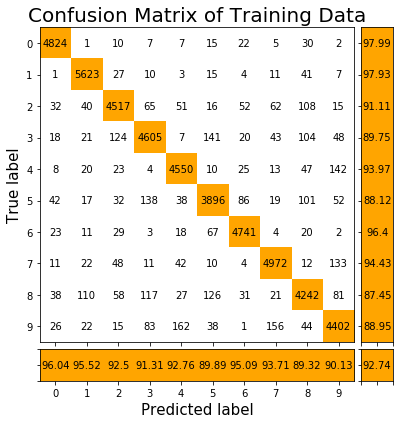

In [31]:
# Find the accuracy on Training Dataset
predicted_label = blrPredict(W, train_data)
plotConfusionMatrix(train_label,predicted_label,"Confusion Matrix of Training Data")


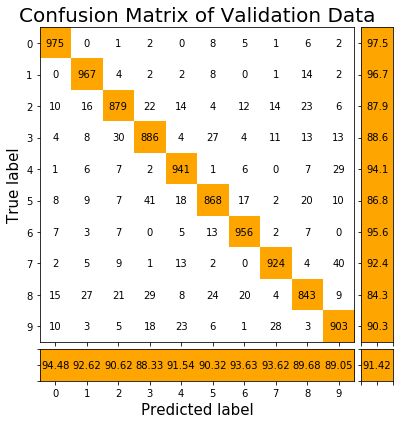

In [32]:
# Find the accuracy on Validation Dataset
predicted_label = blrPredict(W, validation_data)
plotConfusionMatrix(validation_label,predicted_label,"Confusion Matrix of Validation Data")

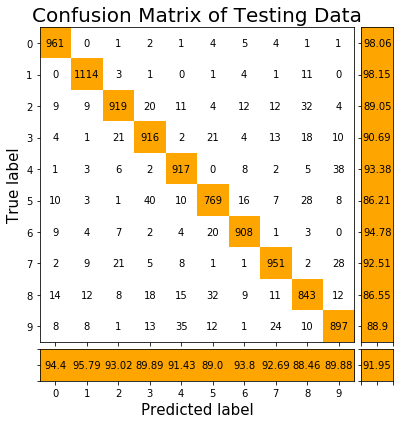

In [33]:
# Find the accuracy on Testing Dataset
predicted_label = blrPredict(W, test_data)
plotConfusionMatrix(test_label,predicted_label,"Confusion Matrix of Testing Data")

In [34]:
"""
Script for Extra Credit Part
"""
# FOR EXTRA CREDIT ONLY
W_b = np.zeros((n_feature + 1, n_class))
initialWeights_b = np.zeros((n_feature + 1, n_class))
opts_b = {'maxiter': 100}

print ("Multi-class Logistic Regression")
args_b = (train_data, Y)
nn_params = minimize(mlrObjFunction, initialWeights_b, jac=True, args=args_b, method='CG', options=opts_b)
W_b = nn_params.x.reshape((n_feature + 1, n_class))

# Find the accuracy on Training Dataset
predicted_label_b = mlrPredict(W_b, train_data)
print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label_b == train_label).astype(float))) + '%')

# Find the accuracy on Validation Dataset
predicted_label_b = mlrPredict(W_b, validation_data)
print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label_b == validation_label).astype(float))) + '%')

# Find the accuracy on Testing Dataset
predicted_label_b = mlrPredict(W_b, test_data)
print('\n Testing set Accuracy:' + str(100 * np.mean((predicted_label_b == test_label).astype(float))) + '%')

Multi-class Logistic Regression

 Training set Accuracy:93.11%

 Validation set Accuracy:92.38%

 Testing set Accuracy:92.53%


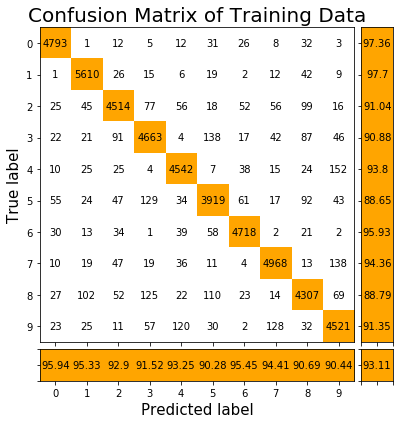

In [35]:
# Find the MLR accuracy on Training Dataset
predicted_label_b = mlrPredict(W_b, train_data)
plotConfusionMatrix(train_label,predicted_label_b,"Confusion Matrix of Training Data")

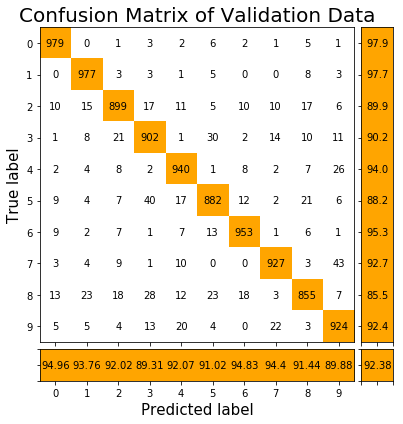

In [36]:
# Find the MLR accuracy on Validation Dataset
predicted_label_b = mlrPredict(W_b, validation_data)
plotConfusionMatrix(validation_label,predicted_label_b,"Confusion Matrix of Validation Data")

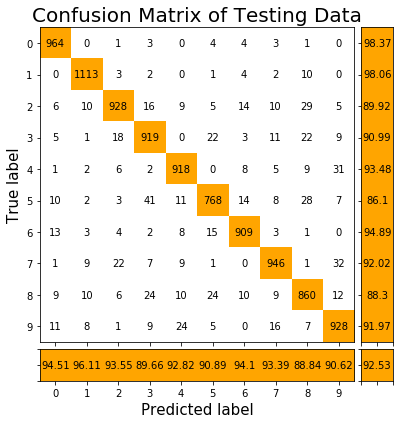

In [37]:
# Find the MLR accuracy on Testing Dataset
predicted_label_b = mlrPredict(W_b, test_data)
plotConfusionMatrix(test_label,predicted_label_b,"Confusion Matrix of Testing Data")

In [50]:
"""
Script for Support Vector Machine
"""

print('\n\n--------------SVM-------------------\n\n')
##################
# YOUR CODE HERE #
##################

svm_train_data = np.zeros((10000, train_data.shape[1]))
svm_train_label = np.zeros((10000, train_label.shape[1]))

start_index = [0, 4923, 10665, 15623, 20754, 25596, 30017, 34938, 40200, 45051]
start = 0
end = 1000
for i in range(len(start_index)):
    svm_train_label[start: end] = train_label[ start_index[i]: start_index[i]+1000 ]
    svm_train_data[start: end] = train_data[ start_index[i]: start_index[i]+1000 ]
    start = start + 1000
    end = end + 1000

print('SVM\nLinear Kernel');
svm_train_label = np.squeeze(svm_train_label)
clf = SVC(kernel = 'linear')
clf.fit(svm_train_data, svm_train_label)
print("Training Accuracy:   "+str(100*clf.score(svm_train_data, svm_train_label))+"%")
print("Test Accuracy:       "+str(100*clf.score(test_data, test_label))+"%")
print("Validation Accuracy: "+str(100*clf.score(validation_data, validation_label))+"%")

print ("\n\nGamma\n");
clf = SVC(kernel='rbf',gamma = 1)
clf.fit(svm_train_data, svm_train_label)
print("Training Accuracy:   "+str(100*clf.score(svm_train_data, svm_train_label))+"%")
print("Test Accuracy:       "+str(100*clf.score(test_data, test_label))+"%")
print("Validation Accuracy: "+str(100*clf.score(validation_data, validation_label))+"%")

print ("\n\nRBF Kernel \n");
clf = SVC(kernel = 'rbf')
clf.fit(svm_train_data, svm_train_label)
print("Training Accuracy:   "+str(100*clf.score(svm_train_data, svm_train_label))+"%")
print("Test Accuracy:       "+str(100*clf.score(test_data, test_label))+"%")
print("Validation Accuracy: "+str(100*clf.score(validation_data, validation_label))+"%")


cvalues  = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
TrainingAccuracy = []
TestAccuracy = []
ValidationAccuracy = []
print ("---------------------------------------------------")
for i in cvalues:
    svm_train_label = np.squeeze(svm_train_label)
    clf = SVC(C=i,kernel='rbf')
    print("Doing for C-Value: ",i)
    clf.fit(svm_train_data, svm_train_label)
    print("CLF Fitting Done!")
    print("Training Accuracy:   ",100*clf.score(svm_train_data, svm_train_label),"%")
    print("Testing Accuracy:    ",100*clf.score(test_data, test_label),"%")
    print("Validation Accuracy: ",100*clf.score(validation_data, validation_label),"%")
    TrainingAccuracy.append(100*clf.score(svm_train_data, svm_train_label))
    TestAccuracy.append(100*clf.score(test_data, test_label))
    ValidationAccuracy.append(100*clf.score(validation_data, validation_label))
    print ("---------------------------------------------------")





--------------SVM-------------------


SVM
Linear Kernel
Training Accuracy:   99.69%
Test Accuracy:       92.21000000000001%
Validation Accuracy: 91.86999999999999%


Gamma

Training Accuracy:   100.0%
Test Accuracy:       19.139999999999997%
Validation Accuracy: 18.4%


RBF Kernel 



/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Training Accuracy:   92.7%
Test Accuracy:       92.25%
Validation Accuracy: 92.01%
---------------------------------------------------
Doing for C-Value:  1


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CLF Fitting Done!
Training Accuracy:    92.7 %
Testing Accuracy:     92.25 %
Validation Accuracy:  92.01 %
---------------------------------------------------
Doing for C-Value:  10


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CLF Fitting Done!
Training Accuracy:    96.72 %
Testing Accuracy:     94.47 %
Validation Accuracy:  94.08 %
---------------------------------------------------
Doing for C-Value:  20


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CLF Fitting Done!
Training Accuracy:    97.89999999999999 %
Testing Accuracy:     94.67 %
Validation Accuracy:  94.6 %
---------------------------------------------------
Doing for C-Value:  30


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CLF Fitting Done!
Training Accuracy:    98.53 %
Testing Accuracy:     94.95 %
Validation Accuracy:  94.78999999999999 %
---------------------------------------------------
Doing for C-Value:  40


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CLF Fitting Done!
Training Accuracy:    99.07000000000001 %
Testing Accuracy:     94.98 %
Validation Accuracy:  94.89 %
---------------------------------------------------
Doing for C-Value:  50


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CLF Fitting Done!
Training Accuracy:    99.26 %
Testing Accuracy:     95.1 %
Validation Accuracy:  94.88 %
---------------------------------------------------
Doing for C-Value:  60


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CLF Fitting Done!
Training Accuracy:    99.5 %
Testing Accuracy:     95.1 %
Validation Accuracy:  94.81 %
---------------------------------------------------
Doing for C-Value:  70


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CLF Fitting Done!
Training Accuracy:    99.65 %
Testing Accuracy:     95.06 %
Validation Accuracy:  94.84 %
---------------------------------------------------
Doing for C-Value:  80


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CLF Fitting Done!
Training Accuracy:    99.72999999999999 %
Testing Accuracy:     95.04 %
Validation Accuracy:  94.8 %
---------------------------------------------------
Doing for C-Value:  90


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CLF Fitting Done!
Training Accuracy:    99.82 %
Testing Accuracy:     94.95 %
Validation Accuracy:  94.95 %
---------------------------------------------------
Doing for C-Value:  100


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CLF Fitting Done!
Training Accuracy:    99.86 %
Testing Accuracy:     94.89 %
Validation Accuracy:  94.99 %
---------------------------------------------------


In [56]:
# Final Choice of Parameters C = 50
print("Using Radial basis function with gamma set to default and for C-Value: ",50)
train_label = np.squeeze(train_label)
clf = SVC(C=i,kernel='rbf')
clf.fit(train_data, train_label)
print("CLF Fitting Done!")
print("Training Accuracy:   ",100*clf.score(train_data, train_label),"%")
print("Testing Accuracy:    ",100*clf.score(test_data, test_label),"%")
print("Validation Accuracy: ",100*clf.score(validation_data, validation_label),"%")
TrainingAccuracy.append(100*clf.score(train_data, train_label))
TestAccuracy.append(100*clf.score(test_data, test_label))
ValidationAccuracy.append(100*clf.score(validation_data, validation_label))

Using Radial basis function with gamma set to default and for C-Value:  50


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CLF Fitting Done!
Training Accuracy:    99.612 %
Testing Accuracy:     97.39999999999999 %
Validation Accuracy:  97.41 %


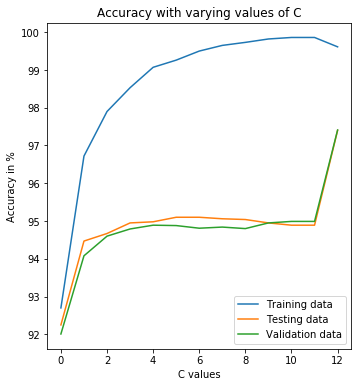

In [59]:
accuracyMatrix = np.column_stack((TrainingAccuracy, TestAccuracy, ValidationAccuracy))

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(accuracyMatrix)
plt.title('Accuracy with varying values of C')
plt.legend(('Training data','Testing data', 'Validation data'), loc = 'best')
plt.xlabel('C values')
plt.ylabel('Accuracy in %')
plt.show()

In [30]:
def plotConfusionMatrix(ytrue,ypred,titlename):
    cm= confusion_matrix(ytrue, ypred)
    kp=np.eye(10)

    cmap = mpl.colors.ListedColormap(['white', 'orange'])
    cmapAcc = mpl.colors.ListedColormap(['orange'])
    F = plt.figure(1, (10.5, 6.5))
    grid = ImageGrid(F, 111,
                     nrows_ncols=(2, 2),
                     axes_pad=0.1,
                     share_all=False,
                 )

    arr=diag(cm)
    
    #im1-confusion matrix, im2-producer's accuracy, im3-user's accuracy, im4-overall accuracy
    im1 = cm
    im2 = np.round(100*arr[:,np.newaxis]/cm.sum(1)[:,np.newaxis],2)
    im3 = np.round(100*arr[np.newaxis,:]/cm.sum(0)[np.newaxis,:],2)
    im4 = np.round(100*(arr.sum()/cm.sum()),2)[np.newaxis][:,np.newaxis]

    #map confusion matrix
    ax = grid[0]
    ax.imshow(kp,cmap)
    for i in range(im1.shape[0]):
        for j in range(im1.shape[1]):
            text = ax.text(j, i, im1[i, j], ha="center", va="center", color="black")
    
    ax.set_title(titlename,fontsize=20)
    ax.set_ylabel("True label",fontsize=15)
    ax.set_yticks(range(10))

    #map producer's accuracy
    ax = grid[1]
    ax.imshow(im2,cmapAcc)
    for i in range(im2.shape[0]):
        text = ax.text(0, i, im2[i][0],ha="center", va="center", color="black")
    
    #map user's accuracy
    ax = grid[2]
    ax.imshow(im3,cmapAcc)
    for i in range(im3.shape[1]):
        text = ax.text(i, 0, im3[0][i], ha="center", va="center", color="black")
   
    ax.set_xticks(range(10))
    ax.set_yticklabels([])
    ax.set_xlabel("Predicted label",fontsize=15)
    
    #map overall accuracy
    ax = grid[3]
    ax.imshow(im4,cmapAcc)
    text = ax.text(0, 0, im4[0][0], ha="center", va="center", color="black")
    ax.set_xticklabels([])
    


In [9]:
# In[60]:



NameError: name 'W' is not defined